# TFIDF + BOW and XGBoost on text data

Finding Similar Quora Questions with BOW, TFIDF and Xgboost

### 1.Import libraries

In [2]:
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score,roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/content/train.csv")
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
print(data.shape)
data = data.dropna(how="any").reset_index(drop=True)
print(data.shape)

(404290, 6)
(404287, 6)


<Axes: xlabel='is_duplicate'>

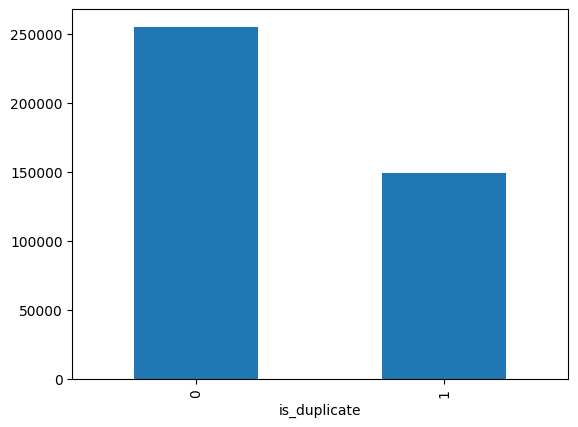

In [5]:
data.groupby('is_duplicate')['id'].count().plot.bar()

### 2.Data Cleaning


In [6]:
data.drop(['id', 'qid1', 'qid2'], axis=1, inplace = True)

i = 0
while i<=len(data):
  print(data.question1[i])
  print(data.question2[i])
  print()
  i+=100000

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What should I ask my friend to get from UK to India?
What is the process of getting a surgical residency in UK after completing MBBS from India?

I really like this guy. He has a girlfriend, but we talk all the time and it seems like he flirts with me. How do I get him to like me?
Should I continue talking with this guy and wait to see if he chooses me over his current girlfriend who cheated on him? What should I do? Please help!

I am having trouble getting a job in the Mechanical Engineering field.  My resume’ is excellent.  My interviewing I have been told is “very good”.  My references are good.  I had my resume’ professionally done.  Should I get a Masters?
If I dont have any degree but I am very good in java. Can I get job at famous corporations?

Why Modi is putting a ban on 500 and 1000 notes?
Who suggested Narendra Modi to stop the circulation of Rs 500

In [7]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

In [8]:
import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [9]:
def clean(text, stem_words = True):

  if pd.isnull(text):
      return ''

  if type(text) != str or text=='':
      return ''

  def pad_str(s):
      return ' '+s+' '

  # clean the text
  text = re.sub("\'s", " ",text) # for cases like "Sam's"
  text = re.sub(" what's ", " what is ", text, flags = re.IGNORECASE)
  text = re.sub("\'ve", " have ", text)
  text = re.sub("can't", "can not", text)
  text = re.sub("n't", " not ", text)
  text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
  text = re.sub("\'re", " are ", text)
  text = re.sub("\'d", " would ", text)
  text = re.sub("\'ll", " will ", text)
  text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
  text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
  text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
  text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
  text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
  text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
  text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
  text = re.sub("[c-fC-F]\:\/", " disk ", text)

  # remove comma b/w the numbers like 10,000 23,566 etc and
  # remove currency symbols
  text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
  text = re.sub('\$', " dollar ", text)
  text = re.sub('\%', " percent ", text)
  text = re.sub('\&', " and ", text)
  text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
  text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
  text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text)
  # replace non-ascii word with special word

  # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
  text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
  text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
  text = re.sub(r" india ", " India ", text)
  text = re.sub(r" switzerland ", " Switzerland ", text)
  text = re.sub(r" china ", " China ", text)
  text = re.sub(r" chinese ", " Chinese ", text)
  text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
  text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
  text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
  text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)
  text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE)
  text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
  text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
  text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE)
  text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
  text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
  text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
  text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
  text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
  text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
  text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
  text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
  text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
  text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
  text = re.sub(r" III ", " 3 ", text)
  text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
  text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
  text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)

  # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"

  text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)

  # Remove punctuation from text
  text = ''.join([c for c in text if c not in punctuation]).lower()
      # Return a list of words
  return text



In [10]:
# apply the functions

data['question1'] = data['question1'].apply(clean)
data['question2'] = data['question2'].apply(clean)

i = 0
while i<=len(data):
  print(data.question1[i])
  print(data.question2[i])
  print()
  i+=100000

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what should i ask my friend to get from england to india
what is the process of getting a surgical residency in england after completing mbbs from india

i really like this guy he has a girlfriend but we talk all the time and it seems like he flirts with me how do i get him to like me
should i continue talking with this guy and wait to see if he chooses me over his current girlfriend who cheated on him what should i do please help

i am having trouble getting a job in the mechanical engineering field  my resume nonasciiword  is excellent  my interviewing i have been told is  nonasciiword very good nonasciiword   my references are good  i had my resume nonasciiword  professionally done  should i get a masters
if i dont have any degree but i am very good in java can i get job at famous corporations

why modi is putting a ban on 500 and 1000 notes
who suggested naren

### 3.Model Building

### 1. Bag of words and XGBoost

In [11]:
count_vector = CountVectorizer(analyzer='word', token_pattern = r'\w{1,}')

concat_df = pd.concat((data['question1'],data['question2'])).unique()
count_vector.fit(concat_df)

CountVectorizer(token_pattern='\\w{1,}')

The `scipy.sparse.hstack` is used to stack sparse matrices horizontally (column wise).

In [14]:
from scipy.sparse import hstack

In [12]:
trainq1 = count_vector.transform(data['question1'].values)
trainq2 = count_vector.transform(data['question2'].values)

# stack them together
labels = data['is_duplicate'].values
x = hstack((trainq1, trainq2))

X_train,X_valid,y_train,y_valid = train_test_split(x,labels, test_size = 0.20,
                                                   random_state = 42)
xgb_model = xgb.XGBClassifier(max_depth=15, learning_rate = 0.01)
xgb_model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:29:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimator=10, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
from sklearn.metrics import classification_report,accuracy_score

xgb_prediction = xgb_model.predict(X_valid)
print('training score:', accuracy_score(y_train, xgb_model.predict(X_train)))
print('validation score:', accuracy_score(y_valid, xgb_model.predict(X_valid)))
print(classification_report(y_valid, xgb_prediction))

training score: 0.7075215889731595
validation score: 0.6981869450147171
              precision    recall  f1-score   support

           0       0.68      0.98      0.80     51026
           1       0.85      0.22      0.35     29832

    accuracy                           0.70     80858
   macro avg       0.77      0.60      0.58     80858
weighted avg       0.74      0.70      0.64     80858



### 2.Word level TF-IDF

In [12]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',
                             ngram_range=(2,3), max_features=5000)
tfidf_vect.fit(concat_df)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')

In [15]:
trainq1_trans = tfidf_vect.transform(data['question1'].values)
trainq2_trans = tfidf_vect.transform(data['question2'].values)

labels = data[['is_duplicate']].values
X = hstack((trainq1_trans,trainq2_trans))

X_train,X_valid,y_train,y_valid = train_test_split(X,labels, test_size = 0.33, random_state = 42)

In [24]:
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=10,
                              learning_rate=0.1,objective='binary:logistic')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
xgb_prediction = xgb_model.predict(X_valid)
print('word level tf-idf training score:', accuracy_score(y_train, xgb_model.predict(X_train)))
print('word level tf-idf validation score:', accuracy_score(y_valid, xgb_model.predict(X_valid)))
print(classification_report(y_valid, xgb_prediction))

word level tf-idf training score: 0.6704052098408104
word level tf-idf validation score: 0.6672862871491212
              precision    recall  f1-score   support

           0       0.66      0.99      0.79     84267
           1       0.85      0.12      0.21     49148

    accuracy                           0.67    133415
   macro avg       0.75      0.55      0.50    133415
weighted avg       0.73      0.67      0.58    133415



### 3. N-Gram Level TF-IDF

In [20]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(concat_df)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')

In [21]:
trainq1_trans = tfidf_vect_ngram.transform(data['question1'].values)
trainq2_trans = tfidf_vect_ngram.transform(data['question2'].values)
labels = data['is_duplicate'].values

X = hstack((trainq1_trans,trainq2_trans))

X_train,X_valid,y_train,y_valid = train_test_split(X,labels, test_size = 0.33, random_state = 42)

In [27]:
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=10, learning_rate=0.1,
                              objective='binary:logistic')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
xgb_prediction = xgb_model.predict(X_valid)
print('n-gram level tf-idf training score:', accuracy_score(y_train, xgb_model.predict(X_train)))
print('n-gram level tf-idf validation score:', accuracy_score(y_valid, xgb_model.predict(X_valid)))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.6476084645146046
n-gram level tf-idf validation score: 0.648285425177079
              precision    recall  f1-score   support

           0       0.64      0.99      0.78     84267
           1       0.86      0.05      0.10     49148

    accuracy                           0.65    133415
   macro avg       0.75      0.52      0.44    133415
weighted avg       0.72      0.65      0.53    133415

